In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 81 kB 3.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-py3-none-any.whl size=123337 sha256=5540f8c4163541b891969299b1e08397fbc2f9f10d62dcca68505669c8902c55
  Stored in directory: /root/.cache/pip/wheels/5a/34/6c/17406cadd88634de11a062015d04d1de556b45c9921752805a
Successfully built sentence-transformers


In [3]:
!nvidia-smi 

Fri May 28 15:42:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-v2')

  0%|          | 0.00/245M [00:00<?, ?B/s]

In [5]:
data = pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [6]:
import gc
df = data[['Title','Plot']]
del data
gc.collect()

265

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['Plot'],inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


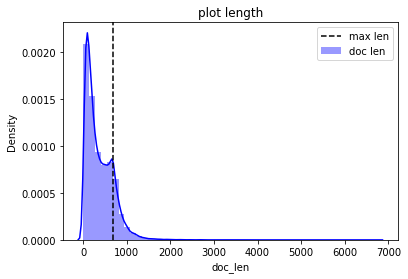

In [8]:
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [9]:
!pip install faiss-gpu

     |████████████████████████████████| 89.4 MB 67 kB/s 


In [10]:
import faiss
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

Batches:   0%|          | 0/1059 [00:00<?, ?it/s]

In [11]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot'][:500]
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [12]:
from pprint import pprint

query="Terrors attack and people running around for help"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',pprint(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07604312896728516


{'Plot': '"The Terror", a killer whose identity is unknown, occupies an '
         'English country house that has been converted into an inn. Guests, '
         'including the spiritualist Mrs. Elvery and detective Ferdinand Fane, '
         'are frightened by strange noises and mysterious organ music. Connors '
         'and Marks, two men just released from jail, have sworn revenge upon '
         '"The Terror". Following a night of mayhem that includes murder, the '
         'identity of "The Terror" is revealed.[1]',
 'Title': 'The Terror'}
	 None
{'Plot': 'A young girl is haunted by nightmares of suicide and murder.[3]',
 'Title': 'Cassandra'}
	 None
{'Plot': 'Having robbed and thoroughly destroyed a gas station, a group of '
         'street thugs with their own gripes against society sit in a '
         'convenience store and out of sheer boredom, decide to rob the same '
         'gas station (as the title card reads, "Why do t

In [13]:
from pprint import pprint

query="movie about romance and pain of seperation"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',pprint(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07551860809326172


{'Plot': 'This film is another tear jerker which is based on relationships.',
 'Title': 'Thavarina Runa'}
	 None
{'Plot': 'The film is about romance and has music as its primary element.',
 'Title': 'Kalgejje'}
	 None
{'Plot': 'Apaaratha is an emotional family film.', 'Title': 'Apaaratha'}
	 None


In [14]:
paragraphs=df.Plot.tolist()

In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (

In [16]:
#Select the device
device = 'cuda'
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (

In [17]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

In [18]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [19]:
with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

  0%|          | 0/2117 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
100%|██████████| 2117/2117 [3:14:02<00:00,  5.50s/it]


In [20]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

train_examples = [] 
with open('generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('distilbert-base-uncased')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/21168 [00:00<?, ?it/s]

In [21]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os

model = SentenceTransformer('./search/search-model')

In [22]:
!zip -r search_model.zip "./search"

  adding: search/ (stored 0%)
  adding: search/search-model/ (stored 0%)
  adding: search/search-model/config.json (stored 0%)
  adding: search/search-model/1_Pooling/ (stored 0%)
  adding: search/search-model/1_Pooling/config.json (deflated 47%)
  adding: search/search-model/modules.json (deflated 55%)
  adding: search/search-model/0_Transformer/ (stored 0%)
  adding: search/search-model/0_Transformer/sentence_bert_config.json (deflated 4%)
  adding: search/search-model/0_Transformer/special_tokens_map.json (deflated 40%)
  adding: search/search-model/0_Transformer/pytorch_model.bin (deflated 8%)
  adding: search/search-model/0_Transformer/tokenizer_config.json (deflated 38%)
  adding: search/search-model/0_Transformer/config.json (deflated 44%)
  adding: search/search-model/0_Transformer/vocab.txt (deflated 53%)


In [23]:
from pprint import pprint

query="Terrors attack and people running around for help"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',pprint(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.14910602569580078


{'Plot': '"The Terror", a killer whose identity is unknown, occupies an '
         'English country house that has been converted into an inn. Guests, '
         'including the spiritualist Mrs. Elvery and detective Ferdinand Fane, '
         'are frightened by strange noises and mysterious organ music. Connors '
         'and Marks, two men just released from jail, have sworn revenge upon '
         '"The Terror". Following a night of mayhem that includes murder, the '
         'identity of "The Terror" is revealed.[1]',
 'Title': 'The Terror'}
	 None
{'Plot': 'In India,British troops attempt to rescue the kidnapped son of a '
         'Maharaja.',
 'Title': 'Emerald of the East'}
	 None
{'Plot': 'It is a love story in the backdrop of terrorism set in Assam.',
 'Title': 'Hoomale'}
	 None


In [24]:
from pprint import pprint

query="movie about romance and pain of seperation"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',pprint(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07850933074951172


{'Plot': 'The film is about the family entertaining romantic story.',
 'Title': 'Manasina Maathu'}
	 None
{'Plot': 'Apaaratha is an emotional family film.', 'Title': 'Apaaratha'}
	 None
{'Plot': 'Story a women how facing problem in her life in different stages in '
         'life',
 'Title': 'Ninaivugal'}
	 None
